# CNN Kaggle MNIST Classification

In [1]:
from abc import ABC, abstractmethod
import copy
import time
from typing import Union, Tuple
import os
import shutil
from zipfile import ZipFile

import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
data_path = './data/digit_data/'

if os.path.exists(data_path):
    shutil.rmtree(data_path)
    
with ZipFile('./data/digit-recognizer.zip') as f:
    f.extractall(data_path)
    
data = pd.read_csv('./data/digit_data/train.csv')
test_data = pd.read_csv('./data/digit_data/test.csv')
sample_submission = pd.read_csv('./data/digit_data/sample_submission.csv')

shutil.rmtree(data_path)
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
x = data.drop('label', axis=1)
y = data['label']

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

x_train = x_train.values.reshape(-1, 1, 28, 28)
y_train = y_train.values.reshape(-1, 1)

x_test = x_test.values.reshape(-1, 1, 28, 28)
y_test = y_test.values.reshape(-1, 1)

x_train = x_train / 255 # нейросетям легче, если нормировать значения
x_test =  x_test / 255

# Полносвязные слои

#### $z=y({c({q({l})})})$
#### $q(l)={w_q}\cdot{l}$
#### ${\frac {dz}{dw_q}}={\frac {dz}{dy}}\cdot{\frac {dy}{dc}}\cdot{\frac {dc}{dq}}\cdot{\frac {dq}{dw_q}}={\frac {dz}{dy}}\cdot{\frac {dy}{dc}}\cdot{\frac {dc}{dq}}\cdot{l}$

Это значит, что для нахождения градиента весов i-го слоя нас интересуют произхводные по входу каждого слоя от N до i-1 включительно, они будут накапливаться и попадать в i-й слой как output_error.

Соответственно, для нахождения градиента весов i+1-го слоя, нам необходимо будет знать и производную по входу i-го слоя, так как для i+1-го слоя она будет являться частью накопленной output_error

Таким образом, например, $c$ - тоже функция вида: ${c}={w_c}\cdot{q}$, все, что нас интересует - это то, что она зависит от своего входа $q$, который дальше может зависеть от чего угодно, но на данном этапе, нам нужно посчитать производную ошибки от $w_c$

Получим:
#### ${\frac {dz}{dw_с}}={\frac {dz}{dy}}\cdot{\frac {dy}{dc}}\cdot{\frac {dc}{dw_c}}={\frac {dz}{dy}}\cdot{\frac {dy}{dc}}\cdot{q}$

Как видно, для поиска градиента по весам слоя, необходимо найти в конечном итоге его производную по этим весам, но она домножается на накопленную ошибку по входам всех предыдущих слоев, а значит, чтобы передавать эту ошибку дальше, необходимо считать и производную по входу (таким образом производная ${\frac {dc}{dq}}$ пригодилась при поиске градиента слоя $q$)

In [5]:
class BaseLayer(ABC):
    @abstractmethod
    def __init__(self) -> None:
        pass

    def __call__(self, x: np.array, grad: bool = True) -> np.array:
        return self.forward(x, grad)

    @abstractmethod
    def forward(self, x: np.array, grad: bool = True) -> np.array:
        pass

    @abstractmethod
    def backward(self, output_error: np.array) -> np.array:
        pass


class Linear(BaseLayer):
    """
    Linear class permorms ordinary FC layer in neural networks
    Parameters:
    n_input - size of input neurons
    n_output - size of output neurons
    Methods:
    set_optimizer(optimizer) - is used for setting an optimizer for gradient descent
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    """

    def __init__(self, n_input: int, n_output: int) -> None:
        super().__init__()
        self.input = None
        self.n_input = n_input
        self.n_output = n_output
        self.w = np.random.normal(scale=np.sqrt(2 / (n_input + n_output)), size=(n_input, n_output))
        self.b = np.random.normal(scale=np.sqrt(2 / (n_input + n_output)), size=(1, n_output))

        self.w_optimizer = None
        self.b_optimizer = None

    def set_optimizer(self, optimizer) -> None:
        self.w_optimizer = copy.copy(optimizer)
        self.b_optimizer = copy.copy(optimizer)

        self.w_optimizer.set_weight(self.w)
        self.b_optimizer.set_weight(self.b)

    def forward(self, x: np.array, grad: bool = True) -> np.array:
        self.input = x
        return x.dot(self.w) + self.b

    def backward(self, output_error: np.array) -> np.array:
        assert self.w_optimizer is not None and self.b_optimizer is not None, 'You should set an optimizer'
        w_grad = self.input.T.dot(output_error)
        b_grad = np.ones((1, len(output_error))).dot(output_error)
        input_error = output_error.dot(self.w.T)

        self.w = self.w_optimizer.step(w_grad)
        self.b = self.b_optimizer.step(b_grad)
        return input_error


class Activation(BaseLayer):
    """
    Activation class is used for activation function of the FC layer
    Params:
    activation_function - activation function (e.g. sigmoid, RElU, tanh)
    activation_derivative - derivative of the activation function
    Methods:
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    """

    def __init__(self, activation_function: callable, activation_derivative: callable) -> None:
        super().__init__()
        self.input = None
        self.activation = activation_function
        self.derivative = activation_derivative

    def forward(self, x: np.array, grad: bool = True) -> np.array:
        self.input = x
        return self.activation(x)

    def backward(self, output_error: np.array) -> np.array:
        return output_error * self.derivative(self.input)
    
    
class Ravel(BaseLayer):
    def __init__(self) -> None:
        super().__init__()
        self.input = None

    def forward(self, input_tensor: np.array, grad: bool = False) -> np.array:
        length = len(input_tensor)
        self.input = input_tensor
        return input_tensor.reshape(length, -1)

    def backward(self, output_error: np.array) -> np.array:
        return output_error.reshape(self.input.shape)


class NeuralNetwork:
    """
    NeuralNetwork class is used to build the Neural Network and train it
    Methods:
    use(loss, loss_derivative) - set the loss function and it's derivative
    add_layer(layer) - constructor of the NN, add one of the layers described above
    predict(x, grad) - forward pass through the network
    fit(x, y, n_epochs, x_val, y_val, batch_size, echo) - fit the network
    """

    def __init__(self, optimizer, random_state=None) -> None:
        self.layers = []
        self.loss = None
        self.loss_derivative = None
        if random_state:
            np.random.seed(random_state)
        self.optimizer = optimizer
        self.best_model = None
        self.best_loss = float('inf')

    def use(self, loss: callable, loss_derivative: callable) -> None:
        self.loss = loss
        self.loss_derivative = loss_derivative

    def add_layer(self, layer) -> None:
        if 'set_optimizer' in layer.__dir__():
            layer.set_optimizer(self.optimizer)

        self.layers.append(layer)

    def predict(self, x: np.array, grad: bool = False) -> np.array:
        prediction = x
        for layer in self.layers:
            prediction = layer.forward(prediction, grad=grad)
        return prediction

    def fit(self,
            x: np.array,
            y: np.array,
            n_epochs: int,
            x_val: np.array = None,
            y_val: np.array = None,
            batch_size: int = None,
            echo: bool = True
            ):

        batch_size = batch_size or len(x)
        loss_print_epoch = np.max((1, n_epochs / 100))
        amount_of_batches = np.ceil(len(x) / batch_size).astype(int)
        metric_name = 'val_loss'
        
        self.best_model = copy.deepcopy(self)
        val_history = []

        try:
            for _ in range(n_epochs):
                start_time = time.time()
                # it is good to do permutations in each epoch
                idxs = np.random.permutation(len(x))
                train_error = 0
                for batch_idx in range(amount_of_batches):
                    batch_slice = idxs[batch_idx * batch_size:batch_idx * batch_size + batch_size]
                    x_batch = x[batch_slice]
                    y_batch = y[batch_slice]

                    preds = self.predict(x_batch, grad=True)
                    train_error += self.loss(y_batch, preds)
                    output_error = self.loss_derivative(y_batch, preds)
                    for layer in reversed(self.layers):
                        output_error = layer.backward(output_error)
                if echo:
                    if x_val is not None and y_val is not None:
                        err_val = self.loss(y_val, self.predict(x_val))
                        if err_val < self.best_loss:
                            self.best_model = copy.deepcopy(self)
                            self.best_loss = err_val
                            
                        if _ % loss_print_epoch == 0:
                            print('*' * 30)
                            print(f'Epoch time: {time.time()-start_time}')
                            print(f'Epoch {_}  train_loss:{train_error / amount_of_batches}, {metric_name}:{err_val}')
                    else:
                        if _ % loss_print_epoch == 0:
                            print('*' * 30)
                            print(f'Epoch time: {time.time()-start_time}')
                            print(f'Epoch {_}  train_loss:{train_error / amount_of_batches}')
        except KeyboardInterrupt:
            print('Interrupted by user')
            return self

        return self

# Сверточные слои

В общем виде, логика свертки изображена ниже:

![](./images/convolution.png)

Ядра свертки домножаются на изображение, входных фильтров у свертки столько же, сколько и у входного изображения каналов
На выходе получается изображение с числом каналов равным числу фильтров свертки, в примере на картинке выше: число входных каналов = 3, число выходных (оно же число фильтров свертки) = 2

Небольшой трюк для улучшения вычислительной эффективности самописной свертки (чтобы меньше делать циклов) следующий:
Необходимо вытянуть ядра свертки в строки, число строк в такой матрице = числу фильтров.
Изображение необходимо также преобразовать, чтобы результат применения свертки был матричным произведением (преобразование изображения зависит от паддингов, страйда и тп)

Если изображений несколько, то они конкатенируются по горизонтали

Выходные изображения будут вытянуты в строки размера:
$[{число фильтров (выходных каналов)}, {размер выходного изображения} \cdot {число изображений}]$

Вручную нетрудно убедиться, что результат такой свертки полностью эквивалентен применению обычной свертки

![](./images/convolution_reformatted.svg)

Для слоев пулинга ситуация аналогичная: но необходимо при обратном проходе запоминать места максимумов, так как именно по ним и пойдет ошибка, остальные позиции зануляются

In [6]:
class Conv2D(BaseLayer):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int, padding: int = 0) -> None:
        super().__init__()
        self.in_channels = in_channels  # number of input channels
        self.out_channels = out_channels  # number of output channels
        self.kernel_size = kernel_size  # kernel size, int
        self.stride = stride  # stride, int
        self.padding = padding  # padding, int, only zeros padding

        limit = 1 / np.sqrt(self.kernel_size ** 2)
        self.kernel = np.random.uniform(
            -limit,
            limit,
            size=(self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)
        )

        self.bias = np.zeros((self.out_channels, 1))
        self.kernel_optimizer = None
        self.bias_optimizer = None

        self.input_tensor = None
        self.batch_size = None
        self.reformatted_input = None
        self.reformatted_kernel = None

        self.channel_steps = []

    def set_kernel(self, kernel: np.array) -> None:
        """
        For setting the kernel manually
        """
        assert len(kernel.shape) == 4
        self.kernel = kernel

    def set_optimizer(self, optimizer) -> None:
        self.kernel_optimizer = copy.copy(optimizer)
        self.bias_optimizer = copy.copy(optimizer)

        self.kernel_optimizer.set_weight(self.kernel)
        self.bias_optimizer.set_weight(self.bias)

    def _reformat_kernel(self) -> np.array:
        """
        Reformat the kernel to perform convolution as matrix multiplication
        """
        assert len(self.kernel.shape) == 4
        return self.kernel.reshape((self.out_channels, -1))

    def _reformat_input(self, input_tensor: np.array) -> np.array:
        """
        Reformat the batch of input images to perform convolution as matrix multiplication
        """
        result = []
        for image in input_tensor:
            result.append(self._reformat_image(image))

        return np.hstack(result)

    def _reformat_image(self, image: np.array) -> np.array:
        """
        Reformatting each image in the batch
        """
        result = []
        for channel in image:
            result.append(self._reformat_channel(channel))

        return np.vstack(result)

    def _reformat_channel(self, channel: np.array) -> np.array:
        """
        Reformat each channel in the image with addinction of zeros as padding
        """
        input_map = self._add_padding(channel)

        self.padded_width_in, self.padded_height_in = input_map.shape

        width_in, height_in = channel.shape

        self.width_out = (width_in - self.kernel_size + 2 * self.padding) // self.stride + 1
        self.height_out = (height_in - self.kernel_size + 2 * self.padding) // self.stride + 1

        output_map = []

        write_steps = True
        if self.channel_steps:
            write_steps = False

        for i in range(self.width_out):
            for j in range(self.height_out):
                horizontal_slice_from = i * self.stride
                horizontal_slice_to = self.kernel_size + i * self.stride

                vertical_slice_from = j * self.stride
                vertical_slice_to = self.kernel_size + j * self.stride

                if write_steps:
                    self.channel_steps.append(
                        (horizontal_slice_from, horizontal_slice_to, vertical_slice_from, vertical_slice_to)
                    )

                subsample = input_map[horizontal_slice_from:horizontal_slice_to, vertical_slice_from:vertical_slice_to]
                output_map.append(subsample.reshape(-1, 1))

        return np.hstack(output_map)

    def _add_padding(self, input_tensor: np.array) -> np.array:
        new_width = input_tensor.shape[0] + self.padding * 2
        new_height = input_tensor.shape[1] + self.padding * 2
        padded_map = np.zeros((new_width, new_height))

        padded_map[self.padding:new_width - self.padding, self.padding:new_height - self.padding] = input_tensor
        return padded_map

    def _reformat_forward(self, forward_output: np.array) -> np.array:
        result = []
        for image in forward_output:
            result.append(image.reshape(self.batch_size, self.height_out, self.width_out))
        return np.hstack(result).reshape((self.batch_size, self.out_channels, self.height_out, self.width_out))

    @staticmethod
    def _reformat_output(output_error: np.array) -> np.array:
        images_result = []
        for image in output_error:
            channel_result = []
            for channel in image:
                channel_result.append(channel.ravel())
            images_result.append(np.vstack(channel_result))
        return np.hstack(images_result)

    def _format_image_back(self, image: np.array) -> np.array:
        zeros = np.zeros((self.in_channels, self.padded_width_in, self.padded_height_in))
        elements_in_kernel = self.kernel_size ** 2
        for i in range(self.in_channels):
            for j, line in enumerate(image.T):
                reshaped_conv = line[i * elements_in_kernel:(i + 1) * elements_in_kernel].reshape(self.kernel_size,
                                                                                                  self.kernel_size)

                horizontal_slice_from, horizontal_slice_to, vertical_slice_from, vertical_slice_to = self.channel_steps[
                    j]
                zeros[i][horizontal_slice_from:horizontal_slice_to,
                         vertical_slice_from:vertical_slice_to] = reshaped_conv
        return zeros

    def _cut_padding(self, image: np.array) -> np.array:
        result = []
        for channel in image:
            channel_no_pad = channel[self.padding:self.padded_width_in - self.padding,
                                     self.padding:self.padded_height_in - self.padding]
            result.append(channel_no_pad[np.newaxis, :])
        return np.vstack(result)

    def _reformat_input_error(self, input_error: np.array) -> np.array:
        assert len(input_error.T) % self.batch_size == 0
        size_for_one_image = int(len(input_error.T) / self.batch_size)
        result = []
        for i in range(self.batch_size):
            image = input_error[:, i * size_for_one_image:(i + 1) * size_for_one_image]
            image = self._format_image_back(image)

            if self.padding != 0:
                image = self._cut_padding(image)

            result.append(image[np.newaxis, :])
        return np.vstack(result)

    def forward(self, input_tensor: np.array, grad: bool = False) -> np.array:
        assert len(input_tensor.shape) == 4
        self.input_tensor = input_tensor
        self.batch_size = self.input_tensor.shape[0]

        self.reformatted_input = self._reformat_input(input_tensor)
        self.reformatted_kernel = self._reformat_kernel()

        result = self.reformatted_kernel.dot(self.reformatted_input) + self.bias
        return self._reformat_forward(result)

    def backward(self, output_error: np.array) -> np.array:
        assert self.kernel_optimizer is not None and self.bias_optimizer is not None, 'You should set an optimizer'
        output_error = self._reformat_output(output_error)
        w_grad = output_error.dot(self.reformatted_input.T).reshape(self.kernel.shape)
        b_grad = output_error.dot(np.ones((output_error.shape[1], 1)))

        self.kernel = self.kernel_optimizer.step(w_grad)
        self.bias = self.bias_optimizer.step(b_grad)

        input_error = self.reformatted_kernel.T.dot(output_error)
        input_error = self._reformat_input_error(input_error)
        return input_error


class MaxPool2D(BaseLayer):
    def __init__(self, kernel_size: int, stride: int, padding: int = 0) -> None:
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.input_tensor = None
        self.channel_steps = []

    def _reformat_input(self, input_tensor: np.array) -> np.array:
        result = []
        grad_result = []
        for image in input_tensor:
            forward_result, grad = self._reformat_image(image)
            result.append(forward_result)
            grad_result.append(grad)

        self.grad = grad_result
        return np.vstack(result)

    def _reformat_image(self, image: np.array) -> np.array:
        result = []
        grad_result = []
        for channel in image:
            forward_result, grad = self._reformat_channel(channel)
            result.append(forward_result)
            grad_result.append(grad)

        return np.vstack(result), grad_result

    def _reformat_channel(self, channel: np.array) -> Tuple[np.array, np.array]:
        input_map = self._add_padding(channel)

        width_in, height_in = channel.shape

        self.width_out = (width_in - self.kernel_size + 2 * self.padding) // self.stride + 1
        self.height_out = (height_in - self.kernel_size + 2 * self.padding) // self.stride + 1

        output_map = np.zeros((self.height_out, self.width_out))

        grad = []

        write_steps = True
        if self.channel_steps:
            write_steps = False

        for i in range(self.width_out):
            for j in range(self.height_out):
                horizontal_slice_from = i * self.stride
                horizontal_slice_to = self.kernel_size + i * self.stride

                vertical_slice_from = j * self.stride
                vertical_slice_to = self.kernel_size + j * self.stride

                if write_steps:
                    self.channel_steps.append(
                        (horizontal_slice_from, horizontal_slice_to, vertical_slice_from, vertical_slice_to)
                    )

                subsample = input_map[horizontal_slice_from:horizontal_slice_to, vertical_slice_from:vertical_slice_to]
                output_map[i][j] = np.max(subsample)

                grad.append(np.argmax(subsample))

        return output_map, grad

    def _add_padding(self, input_tensor: np.array) -> np.array:
        new_width = input_tensor.shape[0] + self.padding * 2
        new_height = input_tensor.shape[1] + self.padding * 2
        padded_map = np.zeros((new_width, new_height))

        padded_map[self.padding:new_width - self.padding, self.padding:new_height - self.padding] = input_tensor
        return padded_map

    def _rebuild_output_error(self, output_error: np.array) -> np.array:
        zeros = np.zeros(self.input_tensor.shape)
        for image_num, image in enumerate(output_error):
            for channel_num, channel in enumerate(image):
                for i in range(self.width_out * self.height_out):
                    horizontal_slice_from, horizontal_slice_to, vertical_slice_from, vertical_slice_to \
                        = self.channel_steps[i]

                    slice_ = zeros[image_num][channel_num][horizontal_slice_from:horizontal_slice_to,
                                                           vertical_slice_from:vertical_slice_to]
                    cur_max = self.grad[image_num][channel_num][i]

                    flatten_channel = channel.flatten()
                    flatten_zeros = slice_.flatten()

                    flatten_zeros[cur_max] = flatten_channel[i]

                    slice_ = flatten_zeros.reshape(self.kernel_size, self.kernel_size)
                    zeros[image_num][channel_num][horizontal_slice_from:horizontal_slice_to,
                                                  vertical_slice_from:vertical_slice_to] = slice_
        return zeros

    def forward(self, input_tensor: np.array, grad: bool = False) -> np.array:
        assert len(input_tensor.shape) == 4
        self.input_tensor = input_tensor

        result = self._reformat_input(input_tensor)
        return result.reshape((input_tensor.shape[0], input_tensor.shape[1], self.height_out, self.width_out))

    def backward(self, output_error: np.array) -> np.array:
        return self._rebuild_output_error(output_error)

# Оптимизаторы

Здесь представлен шаблон для оптимизатора любых параметров, а также [ADAM](https://optimization.cbe.cornell.edu/index.php?title=Adam#:~:text=Adam%20optimizer%20is%20the%20extended,was%20first%20introduced%20in%202014.)

In [7]:
class BaseOptimizer(ABC):
    @abstractmethod
    def __init__(self) -> None:
        pass

    @abstractmethod
    def set_weight(self, weight: np.array) -> None:
        pass

    @abstractmethod
    def step(self, grad: np.array) -> np.array:
        pass
    
    
class ADAM(BaseOptimizer):
    """
    Implements Adam algorithm.

    learning_rate (float, optional) – learning rate (default: 1e-3)
    beta1, beta2 (Tuple[float, float], optional) –
    coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
    eps (float, optional) – term added to the denominator to improve numerical stability (default: 1e-8)
    """

    def __init__(self, beta1: float = 0.9, beta2: float = 0.999, eps: float = 1e-8,
                 learning_rate: float = 3e-4, weight_decay: float = 0) -> None:
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        self.EMA1 = None
        self.EMA2 = None

        self.weight = None

    def set_weight(self, weight: np.array) -> None:
        self.weight = weight.copy()
        self.EMA1 = np.zeros(shape=self.weight.shape)
        self.EMA2 = np.zeros(shape=self.weight.shape)

    def step(self, grad: np.array) -> np.array:
        assert self.weight is not None, 'You should set the weight'
        grad = grad.copy() + self.weight_decay * self.weight
        self.EMA1 = (1 - self.beta1) * grad + self.beta1 * self.EMA1
        self.EMA2 = (1 - self.beta2) * grad ** 2 + self.beta2 * self.EMA2
        self.weight -= self.learning_rate * self.EMA1 / (np.sqrt(self.EMA2) + self.eps)

        return self.weight.copy()

# Функция потерь и активации

In [8]:
def cross_entropy_loss(y_true: np.array, a_pred: np.array) -> float:
    """
    CrossEntropyLoss for multi-classification tasks
    :param y_true: 2D vector with classes, i.e. [[0], [3], [4], [1], [2]]
    :param a_pred: scores for each class before softmax function with shape [n_samples, n_classes]
    :return: CrossEntropyLoss
    """
    lenght_y = list(range(len(y_true)))
    arg = -a_pred[lenght_y, y_true.ravel()]
    sum_exp = np.sum(np.exp(a_pred), axis=1)
    loss = np.sum(arg + np.log(sum_exp))
    return loss / len(y_true)


def cross_entropy_loss_derivative(y_true: np.array, a_pred: np.array) -> np.array:
    """
    CrossEntropyLoss derivative for multi-classification tasks
    :param y_true: 2D vector with classes, i.e. [[0], [3], [4], [1], [2]]
    :param a_pred: scores for each class before softmax function with shape [n_samples, n_classes]
    :return: np.array with shape [n_samples, n_classes] with CrossEntropyLoss derivatives for each weight
    """
    lenght_y = list(range(len(y_true)))
    sum_exp = np.sum(np.exp(a_pred), axis=1).reshape(-1, 1)
    loss = np.exp(a_pred.copy()) / sum_exp
    loss[lenght_y, y_true.ravel()] -= 1

    return loss / len(y_true)


def relu(z: Union[np.array, float, int, list]) -> Union[np.array, float, int]:
    """
    ReLU function
    """
    return np.maximum(0, z)


def relu_derivative(z: Union[np.array, float, int, list]) -> np.array:
    """
    ReLU function derivative
    """
    return (z > 0).astype(int)

## Соберем нейросеть

Архитектура - немного измененный [LeNet](https://en.wikipedia.org/wiki/LeNet), только с [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) в качестве функции активации

Так как все-таки модуль сверток написан вручную, то работает он достаточно медленно

In [9]:
optimizer = ADAM(learning_rate=1e-3)

classification_nn = NeuralNetwork(optimizer, 42)
classification_nn.use(cross_entropy_loss, cross_entropy_loss_derivative)
classification_nn.add_layer(Conv2D(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2))
classification_nn.add_layer(MaxPool2D(2, 2))
classification_nn.add_layer(Activation(relu, relu_derivative))
classification_nn.add_layer(Conv2D(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0))
classification_nn.add_layer(MaxPool2D(2, 2))
classification_nn.add_layer(Activation(relu, relu_derivative))
classification_nn.add_layer(Ravel())
classification_nn.add_layer(Linear(400, 120))
classification_nn.add_layer(Activation(relu, relu_derivative))
classification_nn.add_layer(Linear(120, 84))
classification_nn.add_layer(Activation(relu, relu_derivative))
classification_nn.add_layer(Linear(84, 10))

classification_nn.fit(
    x=x_train,
    y=y_train,
    x_val=x_test,
    y_val=y_test,
    n_epochs=10,
    batch_size=32,
    echo=True
)

preds = np.argmax(classification_nn.predict(x_test), axis=1).reshape(-1, 1)

******************************
Epoch time: 800.0202407836914
Epoch 0  train_loss:0.18472583488470692, val_loss:0.08301266881852988
******************************
Epoch time: 835.3740463256836
Epoch 1  train_loss:0.0670767141465284, val_loss:0.06624281571914292
******************************
Epoch time: 901.5778431892395
Epoch 2  train_loss:0.04446301732173773, val_loss:0.058130213556426356
******************************
Epoch time: 781.5154285430908
Epoch 3  train_loss:0.0363526804755321, val_loss:0.05859034516944277
******************************
Epoch time: 783.0993678569794
Epoch 4  train_loss:0.02904319436614454, val_loss:0.06992599421213257
******************************
Epoch time: 1024.2124621868134
Epoch 5  train_loss:0.02356978075359472, val_loss:0.054019895322420554
******************************
Epoch time: 765.4455499649048
Epoch 6  train_loss:0.019167610680537562, val_loss:0.06124898861876308
******************************
Epoch time: 767.1837525367737
Epoch 7  train_loss:

## Ради интереса взглянем на обученные ядра первого слоя

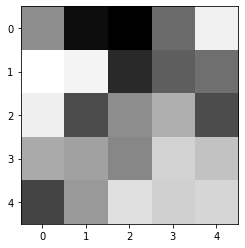

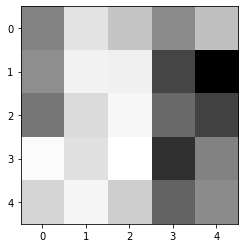

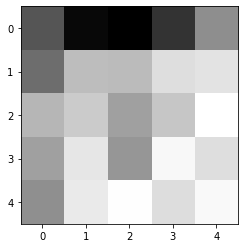

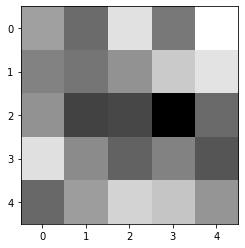

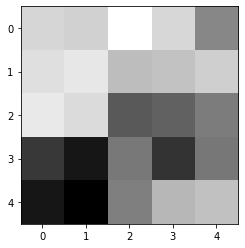

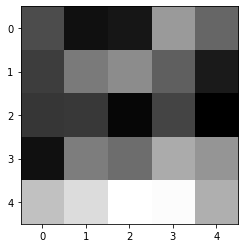

In [11]:
for channel in classification_nn.layers[0].kernel:
    plt.imshow(channel.reshape(5, 5), cmap='Greys')
    plt.pause(0.1)

In [12]:
best_model_predict = np.argmax(classification_nn.best_model.predict(x_test), axis=1).reshape(-1, 1)

In [13]:
accuracy_score(y_test, best_model_predict)

0.9852813852813853

# Построим полносвязную сеть для классификации и оценим ее качество

In [14]:
x_train_fc = x_train.reshape(-1, 784)
x_test_fc = x_test.reshape(-1, 784)
optimizer = ADAM(learning_rate=1e-3)

classification_nn_fc = NeuralNetwork(optimizer, 42)
classification_nn_fc.use(cross_entropy_loss, cross_entropy_loss_derivative)
classification_nn_fc.add_layer(Linear(784, 120))
classification_nn_fc.add_layer(Activation(relu, relu_derivative))
classification_nn_fc.add_layer(Linear(120, 84))
classification_nn_fc.add_layer(Activation(relu, relu_derivative))
classification_nn_fc.add_layer(Linear(84, 10))

classification_nn_fc.fit(
    x=x_train_fc,
    y=y_train,
    x_val=x_test_fc,
    y_val=y_test,
    n_epochs=30,
    batch_size=32,
    echo=True
)

preds_fc = np.argmax(classification_nn_fc.predict(x_test_fc), axis=1).reshape(-1, 1)

******************************
Epoch time: 3.6547372341156006
Epoch 0  train_loss:0.24971544549488192, val_loss:0.16915609880651797
******************************
Epoch time: 3.6830849647521973
Epoch 1  train_loss:0.10699774954248718, val_loss:0.11688477028653002
******************************
Epoch time: 3.8882784843444824
Epoch 2  train_loss:0.07509807720037913, val_loss:0.10925252187258308
******************************
Epoch time: 3.89764666557312
Epoch 3  train_loss:0.05520927678390667, val_loss:0.10917946532038814
******************************
Epoch time: 3.731175661087036
Epoch 4  train_loss:0.041058203198643714, val_loss:0.11457352669917326
******************************
Epoch time: 3.9116370677948
Epoch 5  train_loss:0.030300611525994833, val_loss:0.10596136606275483
******************************
Epoch time: 3.7643418312072754
Epoch 6  train_loss:0.02659439393996012, val_loss:0.10717448275516865
******************************
Epoch time: 4.125145673751831
Epoch 7  train_loss

In [15]:
best_model_predict_fc = np.argmax(classification_nn_fc.best_model.predict(x_test_fc), axis=1).reshape(-1, 1)

In [16]:
accuracy_score(y_test, best_model_predict_fc)

0.96998556998557

### Видно, что качество обычной нейронной сети уступает сверточной
Можно еще покрутить параметры, добавить эпох для сверточной сети и улучшить качество

In [17]:
x_oot = test_data.values.reshape(-1, 1, 28, 28) / 255

preds_oot = classification_nn.best_model.predict(x_oot)
sample_submission.loc[:, 'Label'] = np.argmax(preds_oot, axis=1)
sample_submission.to_csv('./data/digit_submission.csv', index=False) # 0.98356 public leaderboard

In [18]:
with open('./style.css') as f:
    style = f.read()
HTML(style)